In [15]:
import torch 
import torch.nn as nn 
import torch.optim as optim

In [16]:
import pandas as pd
import os
import cv2
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision.models as models
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [17]:
# Set the paths to your data folders
Train_folder = 'PATH to Training_data'
Test_folder = 'PATH to Testing_Data'

IMG_WIDTH = 200
IMG_HEIGHT = 200


In [18]:
class CreateDataset:
    def create_dataset(self, Train_folder, IMG_WIDTH, IMG_HEIGHT):
        img_data_array = []
        class_name = []
        classes = {'driving_license': [1,0,0], 'others': [0,1,0], 'social_security': [0, 0, 1]}
        for PATH, dirs, files in os.walk(Train_folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    picts_path = os.path.join(PATH, file)
                    pict = cv2.imread(picts_path, cv2.COLOR_BGR2RGB)
                    pict = cv2.resize(pict, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
                    pict = np.array(pict)
                    pict = pict.astype('float64')
                    if len(pict.shape) == 3:
                        img_data_array.append(np.array(pict).reshape([3, 200, 200]))
                        class_name.append(classes[os.path.basename(PATH)])
        return img_data_array, class_name

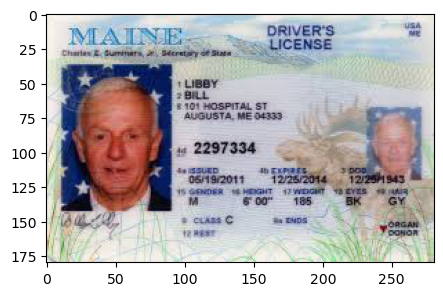

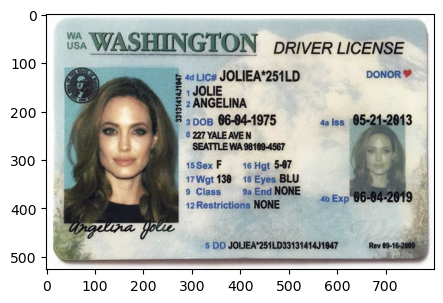

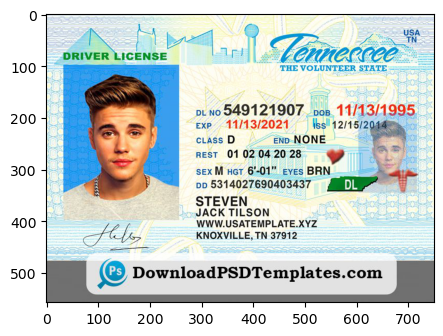

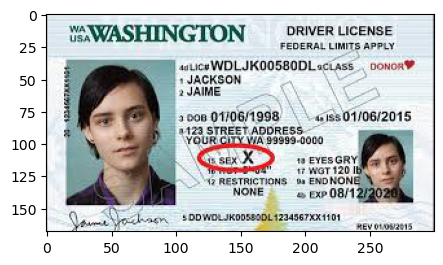

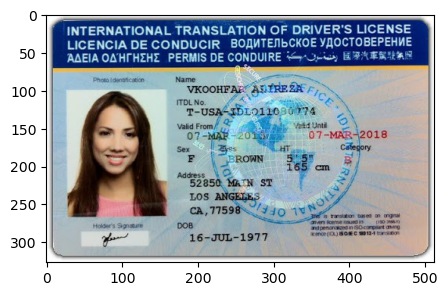

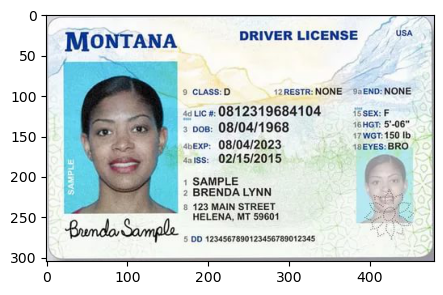

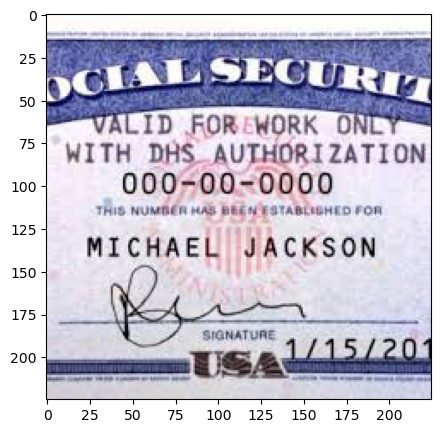

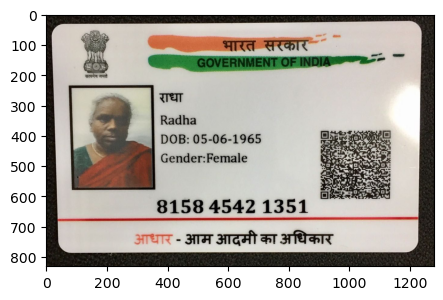

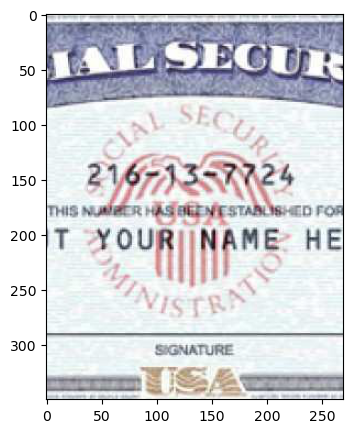

In [19]:
os.listdir(Train_folder)
for path in os.listdir(Train_folder):
    for i in range(3):
        temp_path = Train_folder+"/"+path
        file = random.choice(os.listdir(temp_path))
        image_path= os.path.join(temp_path, file)
        img=mpimg.imread(image_path)
        plt.figure(figsize=(5,5))
        plt.imshow(img)

In [20]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, 3)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [21]:
#Define the TrainModel function
def TrainModel(model, root_dir, trn_loader, tst_loader, num_epochs=25):
    loss_criterion = nn.CrossEntropyLoss()
    optmzr = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trn_loader, 0):
#             labels = labels.unsqueeze(1).float()
            optmzr.zero_grad()
            outputs = model(inputs)
            labels = torch.argmax(labels, dim=1)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optmzr.step()
            running_loss += loss.item()
                
            if i % 1000 == 999:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
    print('Successfully Finished Training the Model')
    torch.save(model.state_dict(), os.path.join(root_dir, 'mymodel.pth'))

In [22]:
#Load the training and testing data using the CreateDataset class:
print("Now Loading the Training Data")
Train_img_data, train_class_name = CreateDataset().create_dataset(Train_folder, IMG_WIDTH, IMG_HEIGHT)
print("Training Data Loaded Successfully")
print("Now Loading the Testing Data")
Test_img_data, test_class_name = CreateDataset().create_dataset(Test_folder, IMG_WIDTH, IMG_HEIGHT)
print("Testing Data Loaded Successfully")
trn_imgs = torch.Tensor(Train_img_data)
trn_lbls = torch.Tensor(train_class_name)
tst_imgs = torch.Tensor(Test_img_data)
tst_lbls = torch.Tensor(test_class_name)

# Create PyTorch datasets
trn_dtst = Data.TensorDataset(trn_imgs, trn_lbls)
tst_dtst = Data.TensorDataset(tst_imgs, tst_lbls)
trn_loader = Data.DataLoader(trn_dtst, batch_size=8, shuffle=True, num_workers=2)
tst_loader = Data.DataLoader(tst_dtst, batch_size=8, shuffle=True, num_workers=2)


Now Loading the Training Data
Training Data Loaded Successfully
Now Loading the Testing Data
Testing Data Loaded Successfully


In [23]:
# Initialize the CNNNet model
# model = CNNNet()

In [24]:
# Train the model
root_dir = 'PATH to output Folder' #typically path to the output folder provided with dataset
model = CNNNet()
TrainModel(model, root_dir, trn_loader, tst_loader, num_epochs=25)
model.load_state_dict(torch.load(os.path.join(root_dir, 'mymodel.pth')))

Successfully Finished Training the Model


<All keys matched successfully>

In [25]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in tst_loader:
        images, labels = data
        labels = torch.argmax(labels, dim=1)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test pictures is: %d %%' % (100 * correct / total))

Accuracy of the network on the test pictures is: 64 %


In [14]:
from torchsummary import summary
# Assuming your model and input size
model = CNNNet()
input_size = (3, 200, 200)
# Print the model summary
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,